In [357]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from time import sleep
import sys

import nltk # for nlp on articles
#nltk.download("stopwords")
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# I. Data Acquisition

## Data Acquisition Utils

In [358]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
        return 0
        list_articles = []
        for c in category_members.values():
            if c.ns == 0:
                list_articles.append(c) 
                #print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = DataAquisitionUtils.fetch_category_members(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        len_time = len(list_articles)*0.05
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int(compt/len_time), int(5*compt/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        len_time = len(list_articles)*0.05
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            try: 
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isdigit() == False]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
            sys.stdout.write('\r')
            sys.stdout.write("[%-20s] %d%%" % ('='*int((i+1)/len_time), int(5*(i+1)/len_time)))
            sys.stdout.flush()
            sleep(0.25)
        return words_df

## NLP Utilities

In [359]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()
        
        dense = tf_idf_vector.todense()
        denselist = dense.tolist()
                
        #tf_idf = matrix where rows are articles and columns are words and values are tfidf score for word in article
        tf_idf = pd.DataFrame(data=denselist, columns=feature_names, index=words_df['article'])
        
        #these are the words that have the biggest tfidf score
        important_words = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf']).head(nb_words).index.values
        
        #only keep the most important words in matrix
        tf_idf = tf_idf[important_words]

        return tf_idf

## Data Acquisition Pipeline

### Fetching the articles of interest

In [360]:
aquire = DataAquisitionUtils()

In [361]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")

In [362]:
# EXECUTE IF YOU DO NOT HAVE PICKLES
# religion_articles = aquire.fetch_category_members(religion_page.categorymembers,0,1)
# science_articles = aquire.fetch_category_members(science_page.categorymembers)

In [363]:
religion_articles = pd.read_pickle('./religion_articles')
science_articles = pd.read_pickle('./science_articles')

#### Hyperlink matrix

In [364]:
# EXECUTE IF YOU DO NOT HAVE CSV
# list_articles = religion_articles + science_articles
# adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
# num_edges = np.count_nonzero(adjacency_matrix)
# print(f"Number of edges in the feature graph: {num_edges}")
# np.savetxt('hyperlinks.csv', adjacency_matrix)

In [365]:
df = pd.read_csv('./hyperlinks.csv.zip')

### Taking the words with the highest TF-IDF

In [366]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

In [367]:
#religion_df = aquire.take_words(religion_articles, stop_words)
religion_df = religion_articles
religion_df = religion_df.drop_duplicates('article')

In [368]:
#science_df = aquire.take_words(science_articles, stop_words)
science_df = science_articles
science_df = science_df.drop_duplicates('article')

In [369]:
religion_labeled_df = religion_df.copy()
religion_labeled_df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

# we select the same number of articles from both categories
# we need a maximal number of data points for a good training process
number_articles = min(len(religion_labeled_df), len(science_labeled_df))

words_df_reduced = pd.concat([religion_labeled_df[:number_articles],\
                              science_labeled_df[:number_articles]],\
                             ignore_index=True)
                              
labels_df = pd.DataFrame(words_df_reduced['label'])
words_df_reduced

,article,words,label
0,Religion,"[religion, social-cultural, system, designated...",0
1,African and African-American women in Christia...,"[christianity, africa, began, egypt, middle, 1...",0
2,Religion and agriculture,"[religion, agriculture, closely, associated, s...",0
3,American Anglican Church,"[anglican, church, north, america, acna, chris...",0
4,American Humanist Association,"[american, humanist, association, aha, non-pro...",0
...,...,...,...
1497,Research council,"[research, funding, term, generally, covering,...",1
1498,Research site,"[research, site, place, people, conduct, resea...",1
1499,Scientific Committee on Antarctic Research,"[scientific, committee, antarctic, research, s...",1
1500,Virtual scientific community,"[virtual, scientific, community, group, people...",1


In [370]:
nlpu = NLPUtilities()

In [371]:
# UNCOMMENT & EXECUTE IF YOU DO NOT HAVE tf_idf_50_words.pickle
# tf_idf = nlpu.TF_IDF(words_df_reduced, 50)
tf_idf = pd.read_pickle('tf_idf_50_words.pickle')
tf_idf

,science,religion,religious,also,god,research,book,scientific,one,church,...,open,scientists,states,students,two,school,nature,state,natural,term
article,,,,,,,,,,,,,,,,,,,,,
Religion,0.040384,0.541282,0.260422,0.040848,0.040620,0.000000,0.005760,0.020669,0.059255,0.035641,...,0.000000,0.000000,0.017344,0.000000,0.010654,0.0,0.038081,0.012429,0.028080,0.058067
African and African-American women in Christianity,0.000000,0.023393,0.039825,0.033837,0.006730,0.005705,0.005726,0.000000,0.013089,0.219650,...,0.000000,0.000000,0.011493,0.000000,0.015886,0.0,0.006309,0.006177,0.000000,0.000000
Religion and agriculture,0.000000,0.069479,0.000000,0.040198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
American Anglican Church,0.000000,0.001557,0.003030,0.017118,0.005375,0.000000,0.006098,0.000000,0.012779,0.260347,...,0.000000,0.000000,0.022951,0.000000,0.019739,0.0,0.001680,0.001645,0.001858,0.000000
American Humanist Association,0.000000,0.009520,0.046307,0.019278,0.038342,0.004643,0.000000,0.000000,0.007102,0.011534,...,0.000000,0.000000,0.023387,0.000000,0.004310,0.0,0.000000,0.010056,0.005680,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Research council,0.085543,0.000000,0.000000,0.012361,0.000000,0.423756,0.000000,0.128667,0.010626,0.000000,...,0.019104,0.027514,0.013995,0.000000,0.012896,0.0,0.015365,0.000000,0.000000,0.023429
Research site,0.000000,0.000000,0.000000,0.000000,0.000000,0.596387,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Scientific Committee on Antarctic Research,0.063570,0.000000,0.000000,0.025720,0.000000,0.072274,0.000000,0.118990,0.022110,0.000000,...,0.039750,0.000000,0.000000,0.000000,0.013417,0.0,0.000000,0.000000,0.000000,0.000000


In [373]:
important_words_df = pd.DataFrame(tf_idf.sum(axis=0, numeric_only=True).sort_values(ascending = False),\
                                  columns=['tfidf'])
important_words_df

,tfidf
science,56.263106
religion,41.039420
religious,37.502533
also,27.991316
god,26.819590
research,26.099541
book,25.830303
scientific,25.473477
one,22.421638
church,21.570589


The weighted TF-IDF matrix $W_{w}$ is our tf_idf dataframe.

In [374]:
features_weight = tf_idf

For the non-weighted TF-IDF $W_{nw}$ where we compute the weights such that for all $i,j$

$(W_{nw})_{i,j} = 1$ if $(W_{w})_{i,j} > 0$, $(W_{nw})_{i,j} = 0$ otherwise

we can do the following

In [375]:
features_no_weight = tf_idf.where(tf_idf <= 0, 1)

For the rest of this project we choose to work with the weighted TF-IDF matrix as it gives more insights into word importance.

In [376]:
features = features_weight

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [377]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [378]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = np.exp((- X**2)/(2 * sigma**2))
        adjacency[adjacency > epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [379]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [380]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## Exploring graph properties

In [381]:
from numpy import dot
from numpy.linalg import norm

def cosine(a,b):
    """
    Function to compute the cosine similarity between two vectors
    Arguments:
    a - first vector
    b - second vector
    Returns:
    cos_sim - the cosine similarity between a and b
    """
    if(norm(a) == 0 or norm(b) == 0):
        return dot(a,b)
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

In [382]:
features_a = np.array(features)

In [383]:
distances = np.array(
    [
        [
            cosine(features_a[i,:],features_a[j,:]) for i in range(0,features_a.shape[0])
        ]
        for j in range(0,features_a.shape[0])
    ]
    ).reshape(features.shape[0],-1)

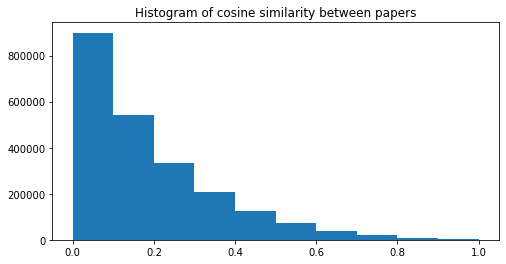

In [384]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of cosine similarity between papers")
plt.hist(distances.flatten());

We notice a heavy-tailed distribution. The similarity between papers is hence concentrated around 0 and 0.2 between most papers but there are some rare papers with very high cosine similarity scores.

In [385]:
important_words_df.head(20)

,tfidf
science,56.263106
religion,41.039420
religious,37.502533
also,27.991316
god,26.819590
research,26.099541
book,25.830303
scientific,25.473477
one,22.421638
church,21.570589


In [386]:
distances = np.nan_to_num(distances)

Let's examine an example of distance distribution for one of the papers.

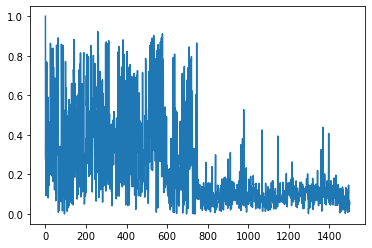

In [387]:
plt.plot(distances[0])

In [388]:
def article_sim_th(threshold, distances=distances):
    feat = np.where(distances > threshold, 1, 0)
    np.fill_diagonal(feat, 0)
    return feat

In [389]:
adjacency_matrix = article_sim_th(0.6)

In [34]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(adjacency_matrix)

In [35]:
# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1264 nodes and 13639 edges.


In [36]:
# getting the average clustering coefficient of our graph
nx.average_clustering(graph)

0.4904574575937421

## Exploring possible clustering in the graph

In [390]:
matrixu = MatrixUtils()

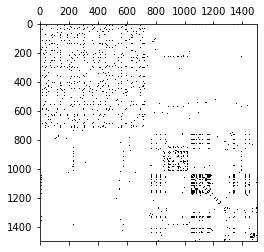

In [391]:
adjacency = matrixu.epsilon_similarity_graph(distances, sigma= 4*np.mean(distances), epsilon=0.7)
plt.spy(adjacency)
plt.show()

In [392]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
neigh.fit(distances)
A = neigh.kneighbors_graph(distances)
knn = A.toarray()
np.fill_diagonal(knn,0)

In [393]:
for i in range(len(knn)):
    for j in range(len(knn)):
        if (knn[i,j] != knn[j,i]):
            knn[i,j] = 0
            knn[j,i] = 0

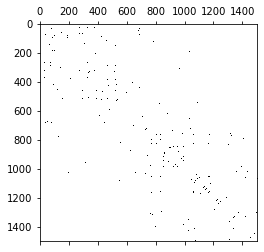

In [394]:
plt.spy(knn)
plt.show()

In [395]:
nodes_df = pd.DataFrame(range(1400), columns = ["X"])
nodes_df["Y"] = np.zeros((1400))

In [396]:
epsilon_df = pd.DataFrame(np.argwhere(adjacency != 0), columns = ["X","Y"] ).drop_duplicates(subset = "X")
epsilon_wo = epsilon_df.merge(nodes_df, on = ["X"], how= "right")

### Removing the nodes that are not connected

In [397]:
tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]]

,science,religion,religious,also,god,research,book,scientific,one,church,...,open,scientists,states,students,two,school,nature,state,natural,term
article,,,,,,,,,,,,,,,,,,,,,
Outline of the creation–evolution controversy,0.022276,0.000000,0.025258,0.015022,0.000000,0.000000,0.000000,0.078182,0.000000,0.031456,...,0.000000,0.0,0.025512,0.00000,0.000000,0.096325,0.028008,0.027424,0.030979,0.000000
Young Humanists International,0.007243,0.000000,0.008212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.008295,0.01207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Bar Ilan Responsa Project,0.000000,0.000000,0.000000,0.021135,0.000000,0.000000,0.000000,0.000000,0.013626,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Free Thought and Official Propaganda,0.000000,0.075093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098039,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.039659,0.000000,0.020587
"Malaysian Consultative Council of Buddhism, Christianity, Hinduism, Sikhism and Taoism",0.000000,0.043633,0.000000,0.025245,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058523,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Siladhara Order,0.014061,0.016389,0.000000,0.009482,0.000000,0.000000,0.000000,0.000000,0.012227,0.000000,...,0.000000,0.0,0.032207,0.00000,0.014839,0.000000,0.000000,0.000000,0.000000,0.000000
Tadibya,0.000000,0.000000,0.000000,0.000000,0.000000,0.025944,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Secular paganism,0.000000,0.000000,0.000000,0.014623,0.000000,0.000000,0.000000,0.025369,0.000000,0.030621,...,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Niraj Jain,0.000000,0.010632,0.010343,0.018454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.00000,0.009627,0.000000,0.011469,0.000000,0.000000,0.000000


In [398]:
distances_wo = np.delete(distances, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 0)
distances_wo = np.delete(distances_wo, epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"], 1)
tf_idf_wo = tf_idf.drop(tf_idf.iloc[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]].index.values)
labels_df_wo = labels_df.drop(labels_df.index[epsilon_wo[pd.isna(epsilon_wo["Y_x"]) == True]["X"]]).reset_index()

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

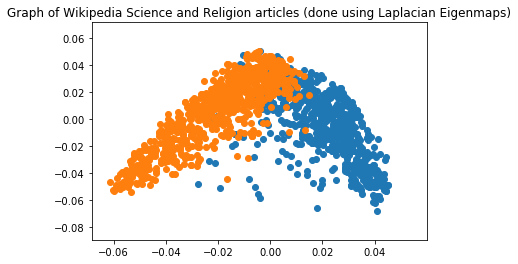

In [399]:
adjacency = matrixu.epsilon_similarity_graph(distances_wo, sigma= 4*np.mean(distances_wo), epsilon=0.70)
laplacian = matrixu.compute_laplacian(distances_wo, normalize=True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(np.nan_to_num(laplacian)) 
twoD_embeddings = (eigenvectors[:,1:3])
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

In [400]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

AttributeError: 'DGLGraph' object has no attribute 'is_directed'

In [ ]:
sorted_pr[:10]

## Exploring possible clustering in the graph after passing it through an ideal filter

In [402]:
# Computing the laplacian
adjacency = matrixu.epsilon_similarity_graph(distances_wo, sigma= 4*np.mean(distances_wo), epsilon=0.70)
laplacian = matrixu.compute_laplacian(adjacency, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [403]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

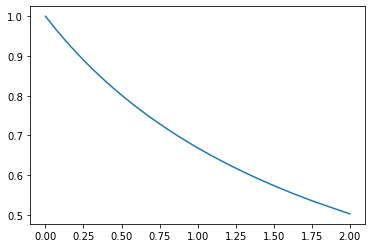

In [404]:
plt.plot(lam, ideal_tk)

In [405]:
filt = FilterUtilities.ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [406]:
graph_filt = nx.from_numpy_matrix(filt)

TypeError: 'DGLGraph' object is not iterable

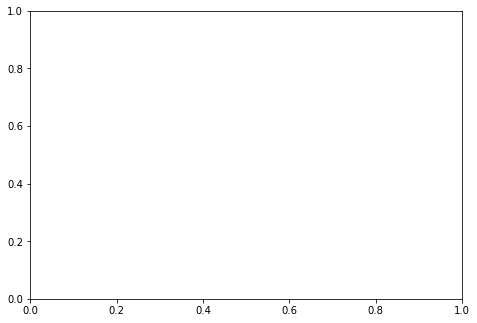

In [407]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [ ]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [ ]:
plt.plot(filt[0])

In [ ]:
adjacency_filt = matrixu.epsilon_similarity_graph(filt, sigma= 4*np.mean(filt), epsilon=0.70)
plt.spy(adjacency_filt)
plt.show()

In [ ]:
laplacian = matrixu.compute_laplacian(filt, normalize=True)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(np.nan_to_num(laplacian)) 
twoD_embeddings = (eigenvectors[:,1:3])
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,0], twoD_embeddings[labels_df_wo[labels_df_wo["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

In [ ]:
nodes_df = pd.DataFrame(range(1378), columns = ["X"])
nodes_df["Y"] = np.zeros((1378))

In [ ]:
epsilon_df_filt = pd.DataFrame(np.argwhere(adjacency_filt != 0), columns = ["X","Y"] ).drop_duplicates(subset = "X")
epsilon_wo_filt = epsilon_df_filt.merge(nodes_df, on = ["X"], how= "right")

In [ ]:
tf_idf_wo.iloc[epsilon_wo_filt[pd.isna(epsilon_wo_filt["Y_x"]) == True]["X"]]

In [ ]:
filt_wo = np.delete(filt, epsilon_wo_filt[pd.isna(epsilon_wo_filt["Y_x"]) == True]["X"], 0)
filt_wo = np.delete(filt_wo, epsilon_wo_filt[pd.isna(epsilon_wo_filt["Y_x"]) == True]["X"], 1)
tf_idf_wo_filt = tf_idf_wo.drop(tf_idf_wo.iloc[epsilon_wo_filt[pd.isna(epsilon_wo_filt["Y_x"]) == True]["X"]].index.values)
labels_df_wo_filt = labels_df_wo.drop(labels_df_wo.index[epsilon_wo_filt[pd.isna(epsilon_wo_filt["Y_x"]) == True]["X"]]).reset_index()

## Visualizing the graph obtained

In [408]:
visu = VisUtils()

### Laplacian Eigenmaps

In [409]:
twoD_embeddings = visu.laplacian_eigenmaps(distances_wo, dim=2, sigma= 4*np.mean(distances), epsilon=0.70, normalize=True)

C:\Users\lilia\.conda\envs\ntds_2019\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


IndexError: index 1482 is out of bounds for axis 0 with size 1482

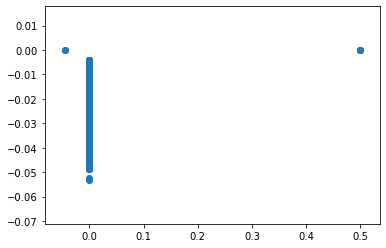

In [410]:
plt.scatter(twoD_embeddings[labels_df[labels_df["label"] == 0].index,0], twoD_embeddings[labels_df[labels_df["label"] == 0].index,1], label=1)
plt.scatter(twoD_embeddings[labels_df[labels_df["label"] == 1].index,0], twoD_embeddings[labels_df[labels_df["label"] == 1].index,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [411]:
np.argmin(twoD_embeddings, 0)

array([666, 221], dtype=int64)

In [412]:
tf_idf.iloc[882]

science       0.022997
religion      0.000000
religious     0.000000
also          0.000000
god           0.000000
research      0.013073
book          0.000000
scientific    0.000000
one           0.009998
church        0.000000
new           0.010693
university    0.000000
world         0.000000
may           0.000000
study         0.000000
first         0.010718
people        0.000000
used          0.000000
christian     0.000000
religions     0.000000
data          0.000000
many          0.000000
time          0.000000
human         0.013439
history       0.000000
see           0.000000
education     0.000000
references    0.007457
list          0.000000
life          0.013205
society       0.000000
law           0.000000
published     0.000000
faith         0.000000
work          0.000000
isbn          0.000000
theory        0.000000
social        0.000000
would         0.000000
studies       0.000000
open          0.000000
scientists    0.034518
states        0.000000
students   

In [413]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(adjacency_filt)

Text(0.5, 1.0, 'Graph of Wikipedia Science and Religion articles (done using tSN-E)')

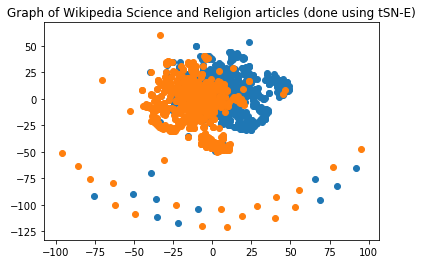

In [415]:
plt.scatter(x_embed[:number_articles,0], x_embed[:number_articles,1], label=1)
plt.scatter(x_embed[number_articles:, 0], x_embed[number_articles:,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

## Cheeger constant

In [112]:
matrixu()

TypeError: 'MatrixUtils' object is not callable

## Heuristic Eigengaps

In [416]:
adjacency_filt = matrixu.epsilon_similarity_graph(filt_wo, sigma= 4*np.mean(filt_wo), epsilon=0.70)
laplacian = matrixu.compute_laplacian(adjacency_filt, normalize = False)
eigenvalues, eigenvectors = matrixu.spectral_decomposition(laplacian)

NameError: name 'filt_wo' is not defined

Text(0.5, 1.0, 'Eigenvalues $L_{comb}$')

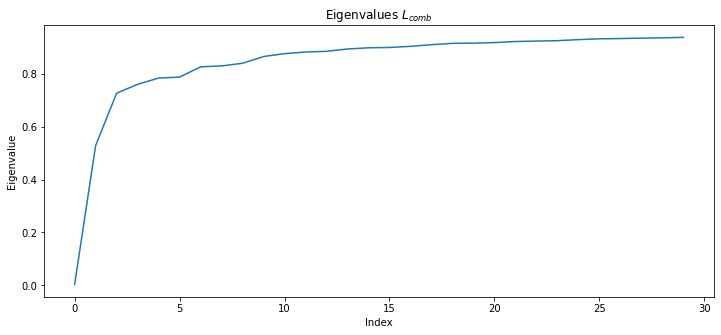

In [417]:
plt.figure(figsize=(12,5))
plt.plot(eigenvalues[0:30])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')

In [418]:
eigenvalues[0:20]

array([0.00358195, 0.52834859, 0.72665148, 0.76021345, 0.7837763 ,
       0.78749846, 0.82629827, 0.82976047, 0.83973843, 0.86529439,
       0.87606415, 0.88232008, 0.88486937, 0.8936567 , 0.89823514,
       0.89948727, 0.90374929, 0.91002319, 0.91505517, 0.91590129])

## Unsupervised learning

In [419]:
adjacency = matrixu.epsilon_similarity_graph(filt_wo, sigma= 4*np.mean(filt_wo), epsilon=0.8)
plt.spy(adjacency)
plt.show()

NameError: name 'filt_wo' is not defined

In [420]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  None
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        laplacian = matrixu.compute_laplacian(adjacency, self.normalize)
        lamb, U = matrixu.spectral_decomposition(laplacian)
        Y = U[:,0:self.n_classes].real
        kmeans = KMeans(n_clusters = self.n_classes).fit(Y)
        y_pred =  kmeans.predict(Y)
        centers = kmeans.cluster_centers_
        return y_pred, centers

In [568]:
spectral_clustering = SpectralClustering(n_classes=6, normalize=True)
y_pred, centers = spectral_clustering.fit_predict(adjacency)
y_pred = pd.DataFrame(y_pred, columns = ["label"])

In [569]:
len(y_pred[y_pred["label"] == 0])

458

In [570]:
tf_idf_wo.iloc[y_pred[y_pred["label"] == 0].index]

,science,religion,religious,also,god,book,scientific,research,one,church,...,review,spiritual,information,system,however,john,islam,group,years,based
article,,,,,,,,,,,,,,,,,,,,,
Blasphemy Day,0.000000,0.037038,0.036001,0.032109,0.000000,0.000000,0.000000,0.000000,0.013721,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Deistic evolution,0.037495,0.008733,0.016977,0.010095,0.337491,0.016831,0.044148,0.000000,0.025883,0.031587,...,0.0,0.011605,0.0,0.000000,0.017126,0.000000,0.0,0.000000,0.018133,0.0
Mesopotamian divination,0.009317,0.000000,0.000000,0.012542,0.024665,0.000000,0.000000,0.000000,0.016079,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.011265,0.0
Outline of the creation–evolution controversy,0.022347,0.000000,0.025296,0.015041,0.000000,0.000000,0.078935,0.000000,0.000000,0.031376,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
List of cycles,0.000000,0.000000,0.008281,0.004924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.011321,0.0,0.000000,0.000000,0.000000,0.0,0.009497,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Physician-scientist,0.059264,0.000000,0.000000,0.039888,0.000000,0.000000,0.023260,0.182058,0.000000,0.000000,...,0.0,0.000000,0.0,0.026332,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Principal investigator,0.025600,0.000000,0.000000,0.017231,0.000000,0.000000,0.030143,0.147456,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.033235,0.000000,0.0
School science technician,0.242312,0.000000,0.000000,0.046598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [571]:
centers.shape

(6, 6)

In [572]:
laplacian = matrixu.compute_laplacian(adjacency, True)
lamb, U = matrixu.spectral_decomposition(laplacian)
Y = U[:,0:6].real

### The clusters

In [612]:
clusters_df = pd.DataFrame([tf_idf_wo_filt.columns.values[np.argsort(-(Y @ centers.T).T@tf_idf_wo_filt.values, 1)[i][:10]] for i in range(6)]).T
clusters_df.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [613]:
clusters_df.loc[0] = tf_idf_wo_filt.index[np.argmax(Y @ centers.T, 0)]
clusters_df.loc[11] = [len(y_pred[y_pred["label"] == i]) for i in range(6)]
clusters_df.loc[12] = [100 - (labels_df_wo_filt.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i])) for i in range(6)]
clusters_df.loc[13] = [labels_df_wo_filt.iloc[y_pred[y_pred["label"] == i].index].sum().values[-1:]*100 / len(y_pred[y_pred["label"] == i]) for i in range(6)]
clusters_df.sort_index(inplace=True)
clusters_df.index = ["Article","1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "Number of articles","Percentage of religion article", "Percentage of science articles"]

In [614]:
clusters_df

,0,1,2,3,4,5
Article,What Is This Thing Called Science?,Indigenous religious beliefs of the Philippines,Collective responsibility,Mañay,Anaisa Pye,Đạo Mẫu
1,science,religion,group,school,often,earth
2,scientific,religious,one,press,well,people
3,book,god,people,isbn,catholic,world
4,research,church,earth,studies,international,book
5,students,religions,example,term,society,life
6,education,also,religion,see,freedom,history
7,scientists,christian,philosophy,references,also,evolution
8,university,science,also,also,references,also
9,also,one,see,space,work,isbn


# Supervised Learning

In [578]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [579]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [580]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [581]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    adjacency, y_pred['label'], range(adjacency.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [582]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = y_pred.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = y_pred.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = y_pred.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [585]:
in_feats = tf_idf_wo_filt.shape[1] 
n_classes = 6
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(tf_idf_wo_filt.values) 
labels = torch.LongTensor(y_pred['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

In [586]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph_wo = nx.from_numpy_matrix(adjacency)
graph = DGLGraph(graph_wo)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 1.7918 | Val Accuracy 0.1309
Epoch 00001 | Time(s) nan | Train Loss 1.8275 | Val Accuracy 0.2945
Epoch 00002 | Time(s) nan | Train Loss 1.7886 | Val Accuracy 0.3309
Epoch 00003 | Time(s) 0.0082 | Train Loss 1.8055 | Val Accuracy 0.3382
Epoch 00004 | Time(s) 0.0082 | Train Loss 1.8034 | Val Accuracy 0.3673
Epoch 00005 | Time(s) 0.0082 | Train Loss 1.7906 | Val Accuracy 0.4073
Epoch 00006 | Time(s) 0.0080 | Train Loss 1.7763 | Val Accuracy 0.4073
Epoch 00007 | Time(s) 0.0081 | Train Loss 1.7809 | Val Accuracy 0.5382
Epoch 00008 | Time(s) 0.0081 | Train Loss 1.7574 | Val Accuracy 0.6836
Epoch 00009 | Time(s) 0.0081 | Train Loss 1.7201 | Val Accuracy 0.6727
Epoch 00010 | Time(s) 0.0081 | Train Loss 1.6462 | Val Accuracy 0.6800
Epoch 00011 | Time(s) 0.0081 | Train Loss 1.5337 | Val Accuracy 0.7091
Epoch 00012 | Time(s) 0.0082 | Train Loss 1.3660 | Val Accuracy 0.7273
Epoch 00013 | Time(s) 0.0080 | Train Loss 1.1701 | Val Accuracy 0.7709
Epoch 00014 | T

In [587]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

[-3.48917    4.167762   1.2503077 -1.7209024]


In [588]:
model

LaplacianPolynomial(
  in=100, out=6, normalization=True
  (dropout): Dropout(p=0.8, inplace=False)
)

In [589]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Spectral response (db)')

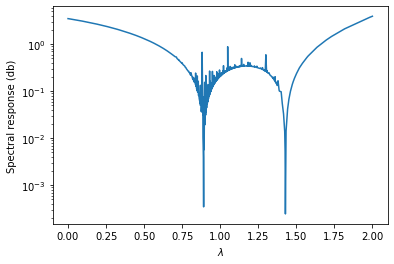

In [590]:
plt.semilogy(lamb, np.abs(polynomial_graph_filter_response(coeff_gcn, lamb)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [591]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = aquire.take_words(list_articles, stop_words, is_title = True)

[====================] 100%

In [592]:
test_df = pd.concat([words_df_reduced,test_df])

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [593]:
features_final = nlpu.TF_IDF(test_df, 100).values
features_final

array([[0.04061253, 0.54364699, 0.26136965, ..., 0.        , 0.02633915,
        0.02359013],
       [0.        , 0.0234867 , 0.03995532, ..., 0.00609518, 0.01962889,
        0.00586007],
       [0.        , 0.06970982, 0.        , ..., 0.        , 0.        ,
        0.0695721 ],
       ...,
       [0.06131579, 0.        , 0.        , ..., 0.        , 0.00935675,
        0.01047523],
       [0.        , 0.00350143, 0.01588425, ..., 0.00363471, 0.00260116,
        0.0093187 ],
       [0.        , 0.        , 0.        , ..., 0.0190229 , 0.        ,
        0.01828915]])

In [594]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [595]:
features_ = torch.FloatTensor(features_final)

In [596]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((4))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [597]:
test_articles(model, graph, features_, mask)

tensor([1, 1, 1, 1])